# Segmentation Notebook
---
Notebook to experiment / compare various segmentation algorithms.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from data.load_data import load_dataset
from source.util import COLOR_TO_HEX, plot_tensors_with_colors, hex_to_rgb

In [2]:
train_dataset = load_dataset(mode='training')
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True)

Train Samples:


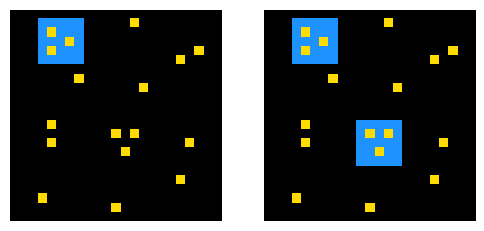

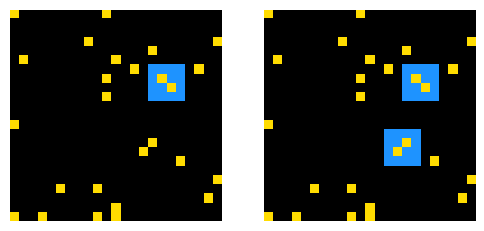

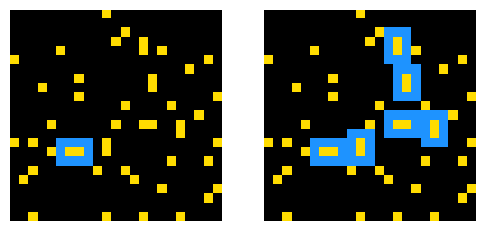

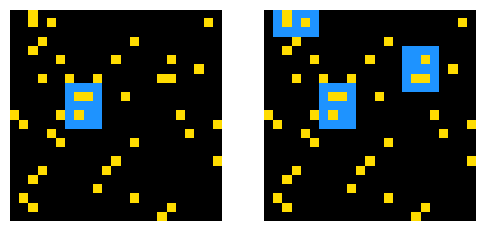

Test Samples:


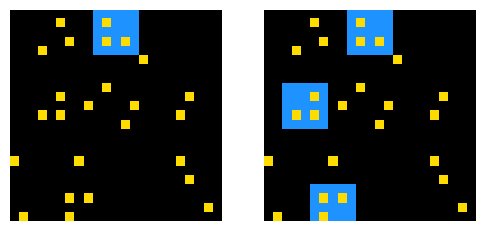

In [3]:
for i, data in enumerate(train_dataloader):
    train = data['train']
    test = data['test']
    
    print(f"Train Samples:\n{'='*100}")
    for t in train:
        plot_tensors_with_colors([t['input'].squeeze(0), t['output'].squeeze(0)])
    
    print(f"Test Samples:\n{'='*100}")
    for t in test:
        plot_tensors_with_colors([t['input'].squeeze(0), t['output'].squeeze(0)])
    break

## Playing around with CV2
---
Generate hierarchal representation of contours

In [4]:
import cv2

In [5]:
import torchvision.models as models
from sklearn.decomposition import PCA
import torch.nn.functional as F

# Load the pretrained ResNet
resnet = models.resnet50(pretrained=True)
resnet = torch.nn.Sequential(*list(resnet.children())[:-1])

c:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\arc-291c\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\lucas\Desktop\UCSD\291C - Program Synthesis\Project\ARC-AGI\arc-291c\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
def plot_image_and_mask(image, mask=None, title=""):
    """
    Plot an image tensor with the corresponding mask.

    Args:
        image (torch.Tensor): A 2D tensor representing the image, with integer values corresponding to keys in COLOR_TO_HEX.
        mask (torch.Tensor, optional): A 2D tensor representing the mask, where '1' indicates masked areas.
        title (str, optional): The title for the plot.

    Returns:
        None. The function displays the image with the mask applied (if provided).
    """
    result_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
    
    for key, hex_value in COLOR_TO_HEX.items():
        rgb_value = hex_to_rgb(hex_value)
        result_image[image == key] = rgb_value

    if mask is not None:
        yellow_tint = np.array([255, 255, 153]) / 255.0
        result_image[mask == 1] = result_image[mask == 1] * 0.6 + yellow_tint * 0.4

    plt.imshow(result_image)
    plt.title(title)
    plt.axis('off')
    plt.show()


In [7]:
def get_contour_mask(image):
    """
    Apply contour detection to the input image and return the contour masks and hierarchy.

    Args:
        image (numpy.ndarray): A 2D numpy array representing the input image, with values expected to be between 0 and 9.

    Returns:
        tuple: A tuple containing:
            - list: A list of 2D numpy arrays (mask) where '1' represents contour areas for each contour.
            - numpy.ndarray: A hierarchy array describing parent-child contour relationships.
    """
    # Scale image values from 0-9 to 0-255
    scaled_image = (image * 255 / 9).astype(np.uint8)
    
    # Find contours and hierarchy
    contours, hierarchy = cv2.findContours(scaled_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    # Create a list of masks for each contour
    contour_masks = []
    for i in range(len(contours)):
        mask = np.zeros_like(scaled_image, dtype=np.uint8)
        cv2.drawContours(mask, contours, i, 1, thickness=cv2.FILLED)
        contour_masks.append(mask)
    
    return contour_masks, hierarchy

In [8]:
def plot_images_horizontally(image, masks, titles):
    """
    Plot multiple images with masks applied side by side with titles.

    Args:
        image (numpy.ndarray): The original input image, a 2D numpy array.
        masks (list of numpy.ndarray): A list of 2D numpy arrays representing masks where '1' indicates masked areas.
        titles (list of str): A list of titles for each image.

    Returns:
        None. Displays the images with masks applied in a horizontal row.
    """
    num_images = len(masks)
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

    for i, (mask, title) in enumerate(zip(masks, titles)):
        # Create the result image with the mask applied
        result_image = np.zeros((image.shape[0], image.shape[1], 3), dtype=np.float32)
        
        # Apply color mapping based on COLOR_TO_HEX
        for key, hex_value in COLOR_TO_HEX.items():
            rgb_value = hex_to_rgb(hex_value)
            result_image[image == key] = rgb_value
        
        # Apply the mask (if provided)
        if mask is not None:
            yellow_tint = np.array([255, 255, 153]) / 255.0
            result_image[mask == 1] = result_image[mask == 1] * 0.6 + yellow_tint * 0.4
        
        # Plot the result image
        axes[i].imshow(result_image)
        axes[i].set_title(title)
        axes[i].axis('off')

    plt.show()



def create_hierarchy_list(hierarchy):
    """Create a list of children for each parent from the hierarchy."""
    # Initialize a list of empty lists to hold children for each index
    children_list = [[] for _ in range(len(hierarchy))]
    
    # Populate the list with children based on hierarchy relationships
    for idx, h in enumerate(hierarchy):
        parent = h[3]  # The parent of the current contour (-1 if no parent)
        if parent != -1:
            children_list[parent].append(idx)
    
    return children_list


def plot_hierarchal_masks(image, masks, hierarchy):
    """
    Plot hierarchal masks according to the parent-child relationships.

    Args:
        image (nparray): The original input image.
        masks (list of numpy arrays): The contour masks.
        hierarchy (numpy.ndarray): The hierarchy array describing parent-child relationships.
    """
    # Create the list of children for each parent using the hierarchy
    children_list = create_hierarchy_list(hierarchy[0])  # Access the first hierarchy level

    # First, plot the original image
    print("Original Input Image:")
    plot_image_and_mask(image)

    # Recursive function to plot the hierarchy of masks
    def plot_recursive(index):
        # If the node has children, we plot them in a horizontal row
        if children_list[index]:
            masks_to_plot = []
            titles = []

            for child in children_list[index]:
                # Prepare the mask for plotting
                masks_to_plot.append(masks[child])
                titles.append(f"Contour {child} (Parent: {index})")

            # Plot the masks of children side by side
            plot_images_horizontally(image, masks_to_plot, titles)

            # Recursively plot the children's children
            for child in children_list[index]:
                plot_recursive(child)

    # Loop through each node and start the recursion for nodes without a parent
    for i in range(len(children_list)):
        parent = hierarchy[0][i][3]
        if parent == -1:  # Root nodes
            plot_recursive(i)

        # Special case: solitary nodes (no parent and no children)
        if not children_list[i] and parent == -1:
            # Plot solitary node's mask
            plot_image_and_mask(image, masks[i], title=f"Solitary Contour {i}")

In [9]:
def flood_fill_segmentation(image, seed_points):
    """
    Perform flood fill on an image using provided seed points for each distinct color and return contour masks.

    Args:
        image (numpy.ndarray): The input image, expected to have distinct colors.
        seed_points (list of tuples): List of (x, y) coordinates to start flood fill for each color.

    Returns:
        contour_masks (list of numpy.ndarray): List of contour masks for each filled region.
    """
    # Ensure the input image is of type uint8
    if image.dtype != np.uint8:
        flood_filled_image = image.astype(np.uint8)
    else:
        flood_filled_image = image.copy()

    # Create a mask that is 2 pixels larger than the input image
    h, w = flood_filled_image.shape[:2]
    mask = np.zeros((h + 2, w + 2), np.uint8)

    # Define the color difference thresholds
    lo_diff = 0  # Lower bound (no difference in color for distinct colors)
    up_diff = 0  # Upper bound (no difference in color for distinct colors)

    # List to hold the contour masks for each region
    contour_masks = []

    # Iterate through the provided seed points
    for seed_point in seed_points:
        # Get the scalar color of the seed point (not a tuple for grayscale/discrete colors)
        seed_color = flood_filled_image[seed_point[1], seed_point[0]]
        
        # Apply flood fill
        cv2.floodFill(flood_filled_image, mask, seedPoint=seed_point, newVal=255, loDiff=lo_diff, upDiff=up_diff)
        
        # Convert the filled region to a binary mask for contour detection
        binary_mask = np.zeros_like(flood_filled_image, dtype=np.uint8)
        binary_mask[flood_filled_image == 255] = 1

        # Find contours for the filled region
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        # Create a contour mask for this region
        contour_mask = np.zeros_like(flood_filled_image, dtype=np.uint8)
        cv2.drawContours(contour_mask, contours, -1, 1, thickness=cv2.FILLED)
        
        # Add the contour mask to the list
        contour_masks.append(contour_mask)

    return contour_masks

In [10]:
def generate_color_masks(image):
    """
    Generate masks for each color in a 2D NumPy array image where pixel values are integers from 0 to 9.

    Args:
        image (numpy.ndarray): A 2D NumPy array representing the image with integer values between 0 and 9.

    Returns:
        list of numpy.ndarray: A list of binary masks where '1' represents the presence of a specific color.
                               Masks are only returned for colors present in the image.
    """
    masks = []
    
    # Iterate over the possible values (0 to 9)
    for color in range(10):
        # Create a binary mask where the pixel value matches the current color
        mask = (image == color).astype(np.uint8)
        
        # Only append the mask if it contains any pixels (i.e., if the color is present)
        if np.any(mask):
            masks.append(mask)
    
    return masks

Train Samples:
Sample 0:


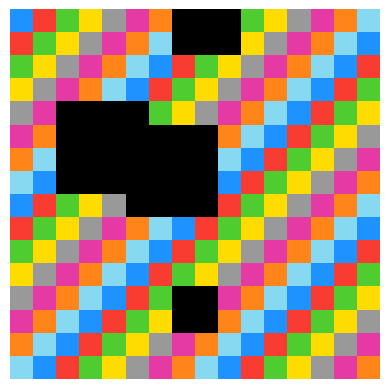


Color Masks:


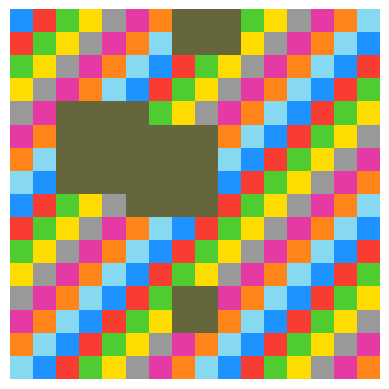

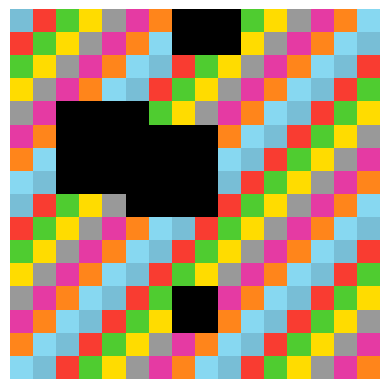

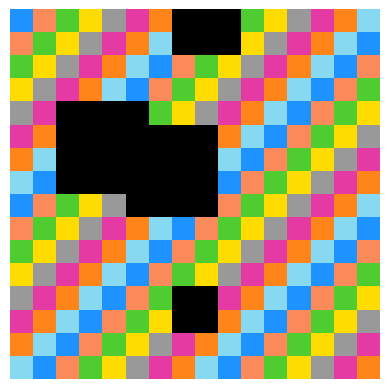

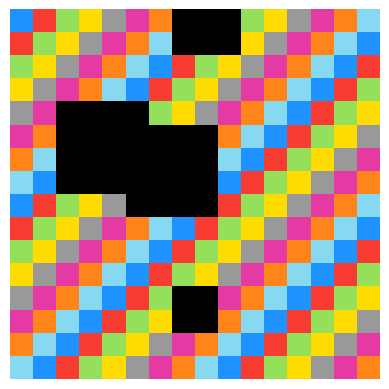

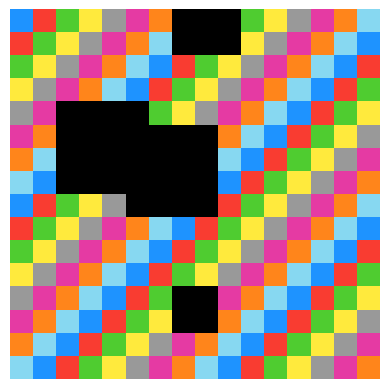

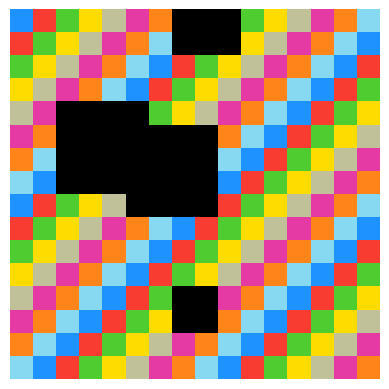

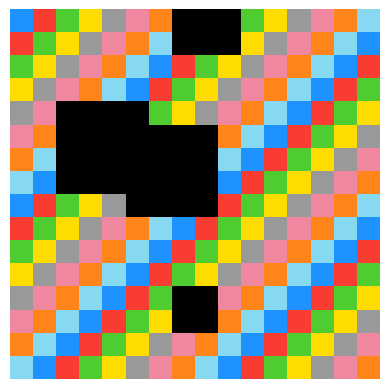

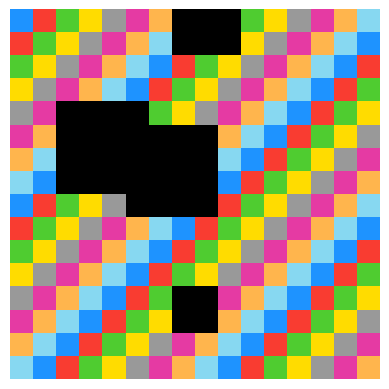

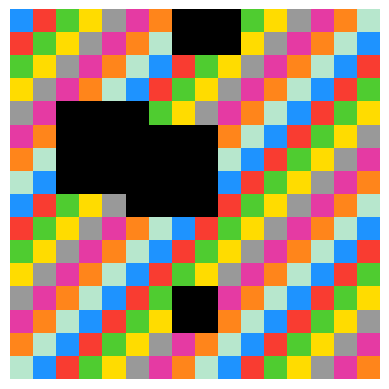


Flood Masks:


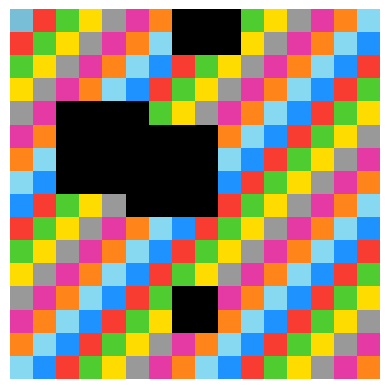


Contour Masks:
Original Input Image:


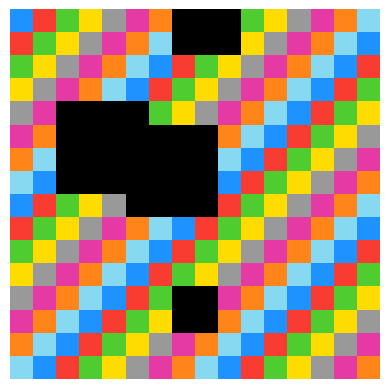

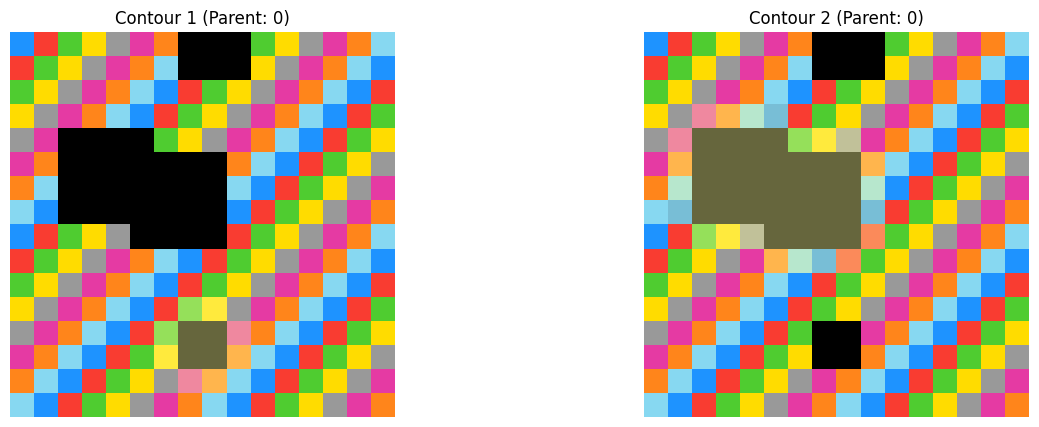

In [11]:
# Main loop processing data
for i, data in enumerate(train_dataloader):
    train = data['train']
    test = data['test']
    
    print(f"Train Samples:\n{'='*100}")
    for i, t in enumerate(test):
        # Will work within numpy for simplicity
        input_image = t['input'].squeeze(0).numpy()
        output = t['output'].squeeze(0).numpy()

        print(f"Sample {i}:\n{'='*100}")
        plot_image_and_mask(input_image)

        # Extract contours, hierarchy, and mask from the input
        print(f"\nColor Masks:\n{'='*100}")
        color_masks = generate_color_masks(input_image)
        for mask in color_masks:
            plot_image_and_mask(input_image, mask)
        
        print(f"\nFlood Masks:\n{'='*100}")
        flood_masks = flood_fill_segmentation(input_image, [(0, 0)])
        for mask in flood_masks:
            plot_image_and_mask(input_image, mask)
        
        # Extract contours, hierarchy, and mask from the input
        print(f"\nContour Masks:\n{'='*100}")
        mask, hierarchy = get_contour_mask(input_image)
        plot_hierarchal_masks(input_image, mask, hierarchy)

        break
    break

    # print(f"Train Samples:\n{'='*100}")
    # for t in train:
    #     # Will work within numpy for simplicity
    #     input_image = t['input'].squeeze(0).numpy()
    #     output = t['output'].squeeze(0).numpy()


    # break

In [12]:
def get_embedding(image, display=False):
    """
    Takes an image (numpy array) and returns the embedding of the image using a pretrained ResNet model.

    Args:
        image (numpy.ndarray): The input image.
        display (bool): Prints the image if set to true.
    """
    image_rgb = np.array([[hex_to_rgb(COLOR_TO_HEX[val]) for val in row] for row in image])

    # Convert to PyTorch tensor, ensure it is float32 and permute dimensions to [3, height, width]
    image_rgb = torch.tensor(image_rgb, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # Add batch dimension

    # Resize the image to 224x224 using nearest-neighbor to avoid blurring
    ## ISSUE: resizing. Need to fix (if we go down this path)
    image_rgb = F.interpolate(image_rgb, size=(224, 224), mode='nearest')

    # Display the image
    if display:
        image_to_display = image_rgb.squeeze(0).permute(1, 2, 0).numpy()
        image_to_display = (image_to_display * 255).astype(np.uint8)
        plt.imshow(image_to_display)
        plt.show()  

    # Get embedding from ResNet
    with torch.no_grad():
        embedding = resnet(image_rgb)

    # Flatten the output (ResNet output shape will be [batch_size, 2048, 1, 1] if height and width are large enough)
    embedding = embedding.view(embedding.size(0), -1)  # Flatten to [batch_size, 2048]

    # Convert to NumPy and apply PCA
    embedding_np = embedding.cpu().numpy().T
    return embedding_np

In [13]:
class ARC_Object:
    def __init__(self, image, mask):
        """
            ARC_Object class to store the grid and other information of the object in the image.

            Args:
                image (numpy.ndarray): A 2D numpy array representing the image.
                mask (numpy.ndarray): A 2D numpy array representing the mask of the object.
        """
        # Get our positional information and num active pixels
        self._init_information(mask)

        # Get grid
        self.grid = (image * mask)[self.top_left[0]:self.top_left[0] + self.height,
                                 self.top_left[1]:self.top_left[1] + self.width]


    def _init_information(self, mask):
        self.active_pixels = np.sum(mask)
        
        # Compute our positions
        x_nonzeros = np.nonzero(np.sum(mask, axis=0))[0]  # Columns with non-zero values
        y_nonzeros = np.nonzero(np.sum(mask, axis=1))[0]  # Rows with non-zero values
        self.top_left = (int(y_nonzeros[0]), int(x_nonzeros[0]))
        self.width = x_nonzeros[-1] - x_nonzeros[0] + 1
        self.height = y_nonzeros[-1] - y_nonzeros[0] + 1


    def get_grid(self):
        return self.grid
    

    def plot_grid(self):
        plot_image_and_mask(self.grid)


    def encode_image(self, image):
        self.embedding = get_embedding(image, display=False)

In [14]:
def extract_objects(image, method='color_mask'):
    """
        Given an image and extraction method, return a list of ARC_Objects for the image.

        Args:
            image (nparray): The input image.
            method (str): The method to use for object extraction. Options are 'color', 'flood', and 'contour'.    
    """
    objects = []

    if method == 'color_mask':
        color_masks = generate_color_masks(image)
        for mask in color_masks:
            objects.append(ARC_Object(image, mask))
    elif method == 'flood':
        flood_masks = flood_fill_segmentation(image, [(0, 0)])
        for mask in flood_masks:
            objects.append(ARC_Object(image, mask))
    elif method == 'contour':
        mask, hierarchy = get_contour_mask(image)
        for m in mask:
            objects.append(ARC_Object(image, m))
    else:
        raise ValueError(f"Invalid method: {method}")

    return objects

Train Samples:


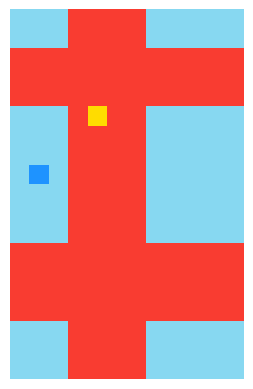

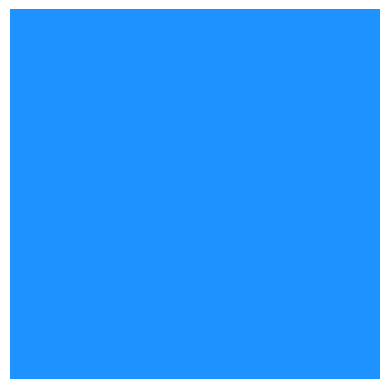

(8, 1) 1 1


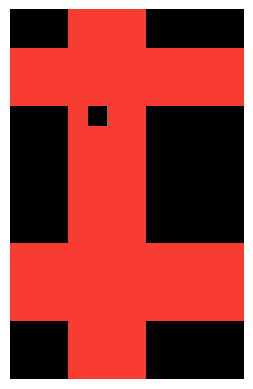

(0, 0) 12 19


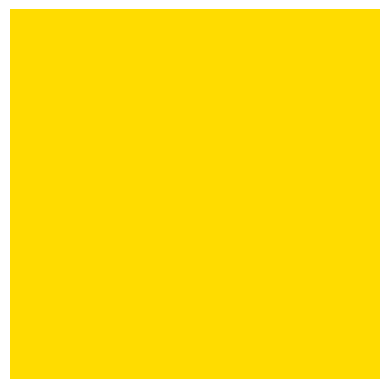

(5, 4) 1 1


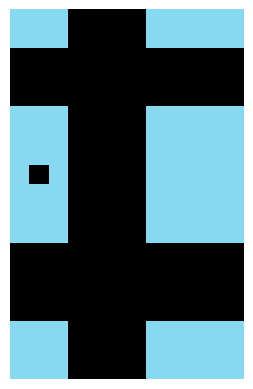

(0, 0) 12 19


In [15]:
my_objs = []

# Main loop processing data
for i, data in enumerate(train_dataloader):
    train = data['train']
    test = data['test']
    
    print(f"Train Samples:\n{'='*100}")
    for i, t in enumerate(train):
        # Will work within numpy for simplicity
        input_image = t['input'].squeeze(0).numpy()
        output = t['output'].squeeze(0).numpy()
        plot_image_and_mask(input_image)
        my_objs = extract_objects(input_image, method='color_mask')
        break
    break

for obj in my_objs:
    obj.plot_grid()
    print(obj.top_left, obj.width, obj.height)

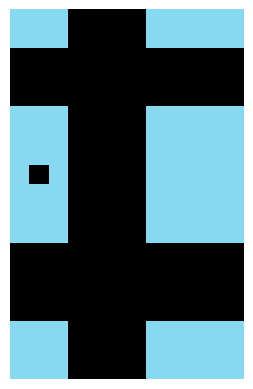

7


In [16]:
test_obj = my_objs[-1]
test_obj.plot_grid()

obj_segmented = extract_objects(test_obj.get_grid(), method='contour')
print(len(obj_segmented))